In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rhishikeshtayade
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset


100%|██████████| 2.70G/2.70G [00:20<00:00, 142MB/s] 


In [ ]:
import os
import tensorflow as tf

In [ ]:
def get_file_counts_by_folder(main_directory):

    if not os.path.isdir(main_directory):
        print(f"Error: The directory '{main_directory}' does not exist.")
        return None

    file_counts = {}

    subfolders = [f.path for f in os.scandir(main_directory) if f.is_dir()]

    for folder_path in subfolders:
        folder_name = os.path.basename(folder_path)
        count = 0
        for _, _, files in os.walk(folder_path):
            count += len(files)
        file_counts[folder_name] = count

    return file_counts

if __name__ == "__main__":
    dataset_path = "/content/new-plant-diseases-dataset"

    counts = get_file_counts_by_folder(dataset_path)

    if counts is not None and counts:
        print("File count per top-level folder:")
        for folder, count in counts.items():
            print(f"- {folder}: {count} files")
    elif counts is not None and not counts:
        print(f"No subfolders found in '{dataset_path}'.")


File count per top-level folder:
- new plant diseases dataset(augmented): 87867 files
- New Plant Diseases Dataset(Augmented): 87867 files
- test: 33 files


In [ ]:
def load_plant_dataset(base_dir, image_width=256, image_height=256, batch_size=32):

  train_dir = os.path.join(base_dir, 'train')
  valid_dir = os.path.join(base_dir, 'valid')

  if not os.path.isdir(train_dir):
        print(f"Error: Training directory '{train_dir}' not found.")
        return None, None
  if not os.path.isdir(valid_dir):
        print(f"Error: Validation directory '{valid_dir}' not found.")
        return None, None

  train_dataset = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      labels='inferred',
      label_mode='categorical',
      image_size=(image_width, image_height),
      batch_size=batch_size
  )

  valid_dataset = tf.keras.utils.image_dataset_from_directory(
      valid_dir,
      labels='inferred',
      label_mode='categorical',
      image_size=(image_width, image_height),
      batch_size=batch_size
  )

  return train_dataset, valid_dataset

dataset_path = "/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

train_ds, valid_ds = load_plant_dataset(dataset_path)

if train_ds and valid_ds:
        print("\nDatasets loaded successfully!")

        print(f"\nTraining dataset has {tf.data.experimental.cardinality(train_ds).numpy()} batches.")
        print(f"Validation dataset has {tf.data.experimental.cardinality(valid_ds).numpy()} batches.")

        class_names = train_ds.class_names
        print(f"\nClass names (labels) found: {class_names}")

        for images, labels in train_ds.take(1):
            print("\nExample batch from training dataset:")
            print(f"Batch shape: {images.shape} (batch_size, height, width, channels)")
            print(f"Labels shape: {labels.shape} (batch_size, num_classes)")

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.

Datasets loaded successfully!

Training dataset has 2197 batches.
Validation dataset has 550 batches.

Class names (labels) found: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'St

In [ ]:
image_path = '/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG'

img_string = tf.io.read_file(image_path)
img_tensor = tf.image.decode_image(img_string)

print(img_tensor.shape)

(256, 256, 3)


In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
import matplotlib.pyplot as plt
import numpy as np


def build_tansfer_learning_model(input_shape, num_classes):

  data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ], name="data_augmentation")

  print("\nBuilding the MobileNetV3 transfer learning model...")
  base_model = MobileNetV3Large(
      weights='imagenet',
      include_top=False,
      input_shape=input_shape
  )

  base_model.trainable = False

  inputs = Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = base_model(x, training=False)
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs, outputs)

  print("Model build successfully!")
  return model

input_shape = (256, 256, 3)
num_classes = 38
model = build_tansfer_learning_model(input_shape, num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC(name='auc')]
)
print("Model compiled successfully!")

model.summary()


Building the MobileNetV3 transfer learning model...


/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model build successfully!
Model compiled successfully!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 8, 8, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       984,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        38,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,019,366 (15.33 MB)

 Trainable params: 1,023,014 (3.90 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
history1 = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs=10
)

Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 187s 79ms/step - accuracy: 0.8185 - auc: 0.9853 - loss: 0.6193 - precision_2: 0.9077 - recall_2: 0.7628 - val_accuracy: 0.9557 - val_auc: 0.9992 - val_loss: 0.1281 - val_precision_2: 0.9630 - val_recall_2: 0.9483
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 212s 84ms/step - accuracy: 0.9331 - auc: 0.9974 - loss: 0.2039 - precision_2: 0.9436 - recall_2: 0.9247 - val_accuracy: 0.9513 - val_auc: 0.9987 - val_loss: 0.1379 - val_precision_2: 0.9572 - val_recall_2: 0.9454
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 190s 78ms/step - accuracy: 0.9444 - auc: 0.9974 - loss: 0.1719 - precision_2: 0.9518 - recall_2: 0.9386 - val_accuracy: 0.9663 - val_auc: 0.9989 - val_loss: 0.0994 - val_precision_2: 0.9704 - val_recall_2: 0.9630
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - accuracy: 0.9528 - auc: 0.9972 - loss: 0.1518 - precision_2: 0.9574 - recall_2: 0.9492 - val_accuracy: 0.9651 - val_auc: 0.9987 - val_loss: 0.1054 - val_precision_2: 0.9695 - v

KeyboardInterrupt: 

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model_weights.weights.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    verbose=0
)

reduce_LROn_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    mode='auto'
)

In [ ]:
model.trainable = True
for layer in model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC(name='auc')]
)

history2 = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=30,
    callbacks=[early_stopping, model_checkpoint, reduce_LROn_plateau]
)

Epoch 1/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 193s 82ms/step - accuracy: 0.9786 - auc: 0.9986 - loss: 0.0730 - precision_1: 0.9804 - recall_1: 0.9776 - val_accuracy: 0.9805 - val_auc: 0.9987 - val_loss: 0.0631 - val_precision_1: 0.9815 - val_recall_1: 0.9795 - learning_rate: 1.0000e-05
Epoch 2/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 186s 77ms/step - accuracy: 0.9798 - auc: 0.9991 - loss: 0.0620 - precision_1: 0.9813 - recall_1: 0.9790 - val_accuracy: 0.9813 - val_auc: 0.9988 - val_loss: 0.0617 - val_precision_1: 0.9819 - val_recall_1: 0.9802 - learning_rate: 1.0000e-05
Epoch 3/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 182s 83ms/step - accuracy: 0.9802 - auc: 0.9988 - loss: 0.0640 - precision_1: 0.9815 - recall_1: 0.9795 - val_accuracy: 0.9817 - val_auc: 0.9989 - val_loss: 0.0593 - val_precision_1: 0.9827 - val_recall_1: 0.9810 - learning_rate: 1.0000e-05
Epoch 4/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 202s 83ms/step - accuracy: 0.9827 - auc: 0.9992 - loss: 0.0555 - precision_1: 0.9839 - recall_1: 0.9815 - val

In [ ]:
# from google.colab import files
# files.download("/content/best_model_weights.weights.h5")

In [ ]:
model.load_weights('/content/best_weights_plant_diseae.weights.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
results = model.evaluate(valid_ds)

for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}\n")

550/550 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.9834 - auc: 0.9990 - loss: 0.0519 - precision: 0.9846 - recall: 0.9827
loss: 0.0509

compile_metrics: 0.9836



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


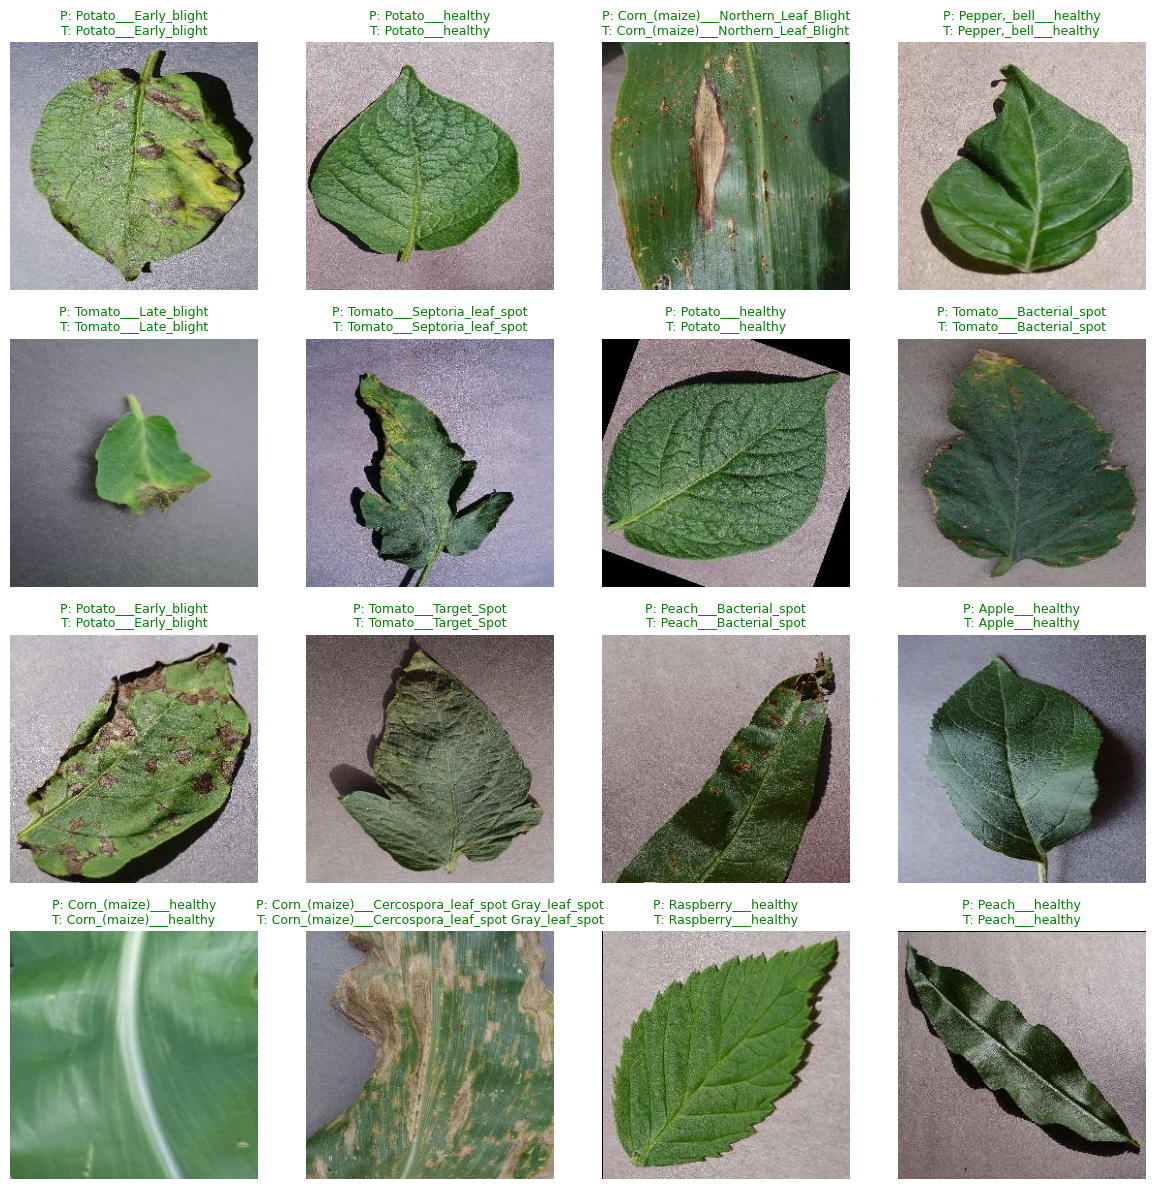

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_predictions(model, dataset, class_names, n_images=16):
    images, labels = next(iter(dataset))

    idxs = np.random.choice(range(len(images)), n_images, replace=False)
    sample_images = images.numpy()[idxs]
    sample_labels = labels.numpy()[idxs]

    preds = model.predict(sample_images)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(sample_labels, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(n_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(sample_images[i].astype("uint8"))
        plt.axis("off")

        true_label = class_names[true_classes[i]]
        pred_label = class_names[pred_classes[i]]

        color = "green" if true_label == pred_label else "red"
        plt.title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=9)
    plt.tight_layout()
    plt.show()

plot_random_predictions(model, valid_ds, train_ds.class_names, n_images=16)